In [110]:
import itertools
import numpy as np
import torch
import torch.utils.data
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [119]:
"""Overall initialization"""

seed = 41
torch.manual_seed(seed)

# Data types
dtype = torch.FloatTensor
np_dtype = np.float32

# PI and Gaussian PDF constants in Torch
pi_tensor = torch.Tensor([np.pi])
pi_variable = Variable(pi_tensor)
normal_log_likelihood_const = -torch.log(torch.sqrt(2 * pi_variable))

# Use gaussian likelihood or L2-norm for reconstruction loss?
use_likelihood = True

# Model parameters
hypersphere_n = 10
latent_size = 5
sigma_x = 0.05

# Training parameters
batch_size = 128
learning_rate = 1e-3

# Data parameters
num_samples = 100000
sigma = 0.05

# Hidden layer units in encoder and decoder (each entry is one layer)
enc_hidden_units_list = [512, 512]
dec_hidden_units_list = [512, 512]

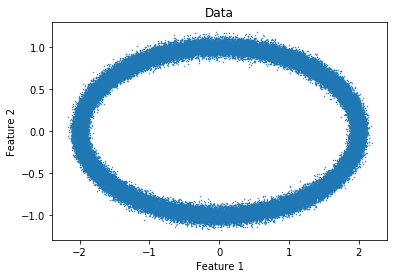

In [120]:
"""Datasets"""

# Generate random data (Circle)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)
u = 2 * np.pi * rng.rand(num_samples)[..., np.newaxis]
eps1 = sigma * rng.randn(num_samples)[..., np.newaxis]
eps2 = sigma * rng.randn(num_samples)[..., np.newaxis]
data = np.hstack([2 * np.cos(u) + eps1, np.sin(u) + eps2])
assert data.shape[0] == num_samples
num_features = data.shape[1]

# # Generate random data (Hypersphere)
# rng = np.random.RandomState(seed)
# u = rng.randn(num_samples, hypersphere_n)
# u /= np.sqrt(np.sum(u**2, axis=1))[:, np.newaxis]
# eps = sigma * rng.randn(num_samples, hypersphere_n)
# data = u + eps
# assert data.shape[0] == num_samples
# num_features = data.shape[1]

# # Generate random data (3 gaussians)
# torch.manual_seed(seed)
# rng = np.random.RandomState(seed)
# x1 = rng.multivariate_normal([1, 1], np.diag([0.1, 0.4]), size=num_samples // 2)
# x2 = rng.multivariate_normal([-1, -1], np.diag([0.1, 0.1]), size=num_samples // 4)
# x3 = rng.multivariate_normal([-1, 1], [[0.1, -0.3], [-0.3, 0.6]], size=num_samples // 4)
# data = np.vstack([x1, x2, x3])
# assert data.shape[0] == num_samples
# num_features = data.shape[1]

# Plot data
plt.clf()
plt.scatter(data[:, 0], data[:, 1], s=0.2)
plt.title("Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Create a torch dataset (use zeros as dummy labels)
dataset = torch.utils.data.TensorDataset(torch.from_numpy(data), torch.zeros(num_samples))
kwargs = {}
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size, shuffle=True, **kwargs)

In [121]:
"""Network model for encoder and decoder"""

class VAE(nn.Module):

    def __init__(self, input_size, latent_size, enc_hidden_units_list, dec_hidden_units_list):
        super(VAE, self).__init__()

        self.latent_size = latent_size

        # Encoder layers
        self.enc_fc_list = nn.ModuleList()
        prev_layer_size = input_size
        for i, num_hidden_units in enumerate(enc_hidden_units_list):
            fc = nn.Linear(prev_layer_size, num_hidden_units)
            self.enc_fc_list.append(fc)
            prev_layer_size = num_hidden_units
        self.enc_mu = nn.Linear(prev_layer_size, latent_size)
        self.enc_logvar = nn.Linear(prev_layer_size, latent_size)

        # Decoder layers
        self.dec_fc_list = nn.ModuleList()
        prev_layer_size = latent_size
        for i, num_hidden_units in enumerate(dec_hidden_units_list):
            fc = nn.Linear(prev_layer_size, num_hidden_units)
            self.dec_fc_list.append(fc)
            prev_layer_size = num_hidden_units
        self.dec_reconstruct = nn.Linear(prev_layer_size, input_size)

        # Activation functions
        self.relu = nn.ReLU()

    def encode(self, x):
        h = x
        for fc in self.enc_fc_list:
            h = fc(h)
            h = self.relu(h)
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar

    def decode(self, z):
        h = z
        for fc in self.dec_fc_list:
            h = fc(h)
            h = self.relu(h)
        return self.dec_reconstruct(h)

    def sample_latent_space(self, num_samples, dtype=torch.FloatTensor, volatile=False):
        z = Variable(torch.randn(num_samples, self.latent_size).type(dtype), volatile=volatile)
        return z

    def sample_latent_space_parametrized(self, mu, logvar):
        if self.training:
          sigma = logvar.mul(0.5).exp_()
          eps = Variable(sigma.data.new(sigma.size()).normal_())
          return eps.mul(sigma).add(mu)
        else:
          return mu

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample_latent_space_parametrized(mu, logvar)
        x_reconstruct = self.decode(z)
        return x_reconstruct, mu, logvar

model = VAE(num_features, latent_size, enc_hidden_units_list, dec_hidden_units_list)

In [122]:
"""Log likelihood and KL divergence"""

def pdf_normal(x, mu, sigma):
    sigma_sq = sigma * sigma
    norm_const = 1 / (np.sqrt(2 * np.pi) * sigma)
    p = torch.exp(-(x - mu) ** 2 / (2 * sigma_sq)) * norm_const
    return p

def log_pdf_normal(x, mu, sigma):
    sigma_sq = sigma * sigma
    log_norm_const = - torch.log(torch.sqrt(2 * pi_variable) * sigma)
    p = -(x - mu) ** 2 / (2 * sigma_sq) + log_norm_const
    return p

def log_pdf_normal_uncorrelated(x, mu, sigma):
    p = 0
    for i in range(mu.data.shape[-1]):
        p += log_pdf_normal(x[..., i], mu[..., i], sigma[..., i])
    return p

def log_pdf_normal_uncorrelated_logvar(x, mu, logvar):
    p = torch.sum(normal_log_likelihood_const - logvar.mul(0.5) - (x - mu).pow(2) / (2 * logvar.exp()), dim=-1)
    return p

def kl_divergence_normal_uncorrelated(mu1, sigma1, mu2, sigma2):
    kld = 0
    for i in range(mu1.data.shape[-1]):
        kld += kl_divergence_normal_univariate(mu1[..., i], sigma1[..., i], mu2[..., i], sigma2[..., i])
    return kld

def kl_divergence_normal_uncorrelated_identity(mu1, sigma1):
    kld = 0.5 * torch.sum(mu1.pow(2) + sigma1.pow(2) - 1 - torch.log(sigma1.pow(2)), dim=-1)
    return kld

def log_pdf_normal_uncorrelated_logvar(x, mu, logvar):
    p = torch.sum(normal_log_likelihood_const - logvar.mul(0.5) - (x - mu).pow(2) / (2 * logvar.exp()), dim=-1)
    return p

def kl_divergence_normal_uncorrelated_identity_logvar(mu1, logvar1):
    kld = 0.5 * torch.sum(mu1.pow(2) + logvar1.exp() - 1 - logvar1, dim=-1)
    return kld

In [123]:
"""Training"""

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

sigma_x_array = Variable(sigma_x * torch.ones(num_features))
logvar_x_array = torch.log(sigma_x_array.pow(2))

def loss_function(true_x, x, mu, logvar, return_loss_components=False):
    # Compute KL-divergence between `N(latent_mu, latent_sigma)` and unit normal distribution
    kld_q = kl_divergence_normal_uncorrelated_identity_logvar(mu, logvar)
    kld_q = torch.mean(kld_q)
    # Compute data loss
    if use_likelihood:
        log_likelihood_x = log_pdf_normal_uncorrelated_logvar(true_x, x, logvar_x_array)
        recon_loss = - torch.mean(log_likelihood_x)
    else:
        recon_loss = torch.mean((true_x - x).pow(2))
    # Total loss
    loss = recon_loss + kld_q
    if return_loss_components:
        return loss, recon_loss, kld_q
    else:
        return loss

model.train()

num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0
    train_recon_loss = 0
    train_kld = 0
    for i, (x, _) in enumerate(train_loader):
        x = Variable(x.type(dtype))

        optimizer.zero_grad()
        reconstruct_x, mu, logvar = model(x)
        loss, recon_loss, kld = loss_function(x, reconstruct_x, mu, logvar, return_loss_components=True)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        train_recon_loss += recon_loss.data[0]
        train_kld += kld.data[0]
        if i % 1000 == 0:
            print("epoch={}, i={}".format(epoch, i))
            print("  loss: {:.4f}, recon_loss: {:.4f}, kld: {:.4f}".format(
                train_loss / (i + 1), train_recon_loss / (i + 1), train_kld / (i + 1)))
    train_loss *= batch_size / num_samples
    train_recon_loss *= batch_size / num_samples
    train_kld *= batch_size / num_samples
    print('====> Train set loss: {:.4f}, recon_loss: {:.4f}, kld: {:.4f}'.format(
        train_loss, train_recon_loss, train_kld))

epoch=0, i=0
  loss: 471.7001, recon_loss: 471.6638, kld: 0.0364
====> Train set loss: 7.6158, recon_loss: 1.3431, kld: 6.2727
epoch=1, i=0
  loss: 2.7840, recon_loss: -2.6580, kld: 5.4419
====> Train set loss: 2.5300, recon_loss: -2.6528, kld: 5.1828
epoch=2, i=0
  loss: 2.5600, recon_loss: -2.5559, kld: 5.1159
====> Train set loss: 2.2562, recon_loss: -2.6131, kld: 4.8693
epoch=3, i=0
  loss: 2.2795, recon_loss: -2.4908, kld: 4.7703
====> Train set loss: 2.0799, recon_loss: -2.6297, kld: 4.7096
epoch=4, i=0
  loss: 2.5491, recon_loss: -2.2775, kld: 4.8266
====> Train set loss: 1.9942, recon_loss: -2.6788, kld: 4.6731
epoch=5, i=0
  loss: 2.0684, recon_loss: -2.5285, kld: 4.5969
====> Train set loss: 1.8176, recon_loss: -2.7868, kld: 4.6044
epoch=6, i=0
  loss: 1.9294, recon_loss: -2.9036, kld: 4.8330
====> Train set loss: 1.7867, recon_loss: -2.8435, kld: 4.6302
epoch=7, i=0
  loss: 1.7060, recon_loss: -2.9658, kld: 4.6718
====> Train set loss: 1.7446, recon_loss: -2.8662, kld: 4.610

====> Train set loss: 1.3484, recon_loss: -3.2103, kld: 4.5586
epoch=66, i=0
  loss: 1.3788, recon_loss: -3.2832, kld: 4.6620
====> Train set loss: 1.3405, recon_loss: -3.2270, kld: 4.5675
epoch=67, i=0
  loss: 1.4482, recon_loss: -3.1073, kld: 4.5556
====> Train set loss: 1.3838, recon_loss: -3.1895, kld: 4.5733
epoch=68, i=0
  loss: 1.3052, recon_loss: -3.2182, kld: 4.5234
====> Train set loss: 1.3154, recon_loss: -3.2150, kld: 4.5303
epoch=69, i=0
  loss: 1.5354, recon_loss: -3.1705, kld: 4.7059
====> Train set loss: 1.3332, recon_loss: -3.2228, kld: 4.5560
epoch=70, i=0
  loss: 1.4296, recon_loss: -3.4301, kld: 4.8597
====> Train set loss: 1.2996, recon_loss: -3.2333, kld: 4.5329
epoch=71, i=0
  loss: 1.5603, recon_loss: -2.8099, kld: 4.3702
====> Train set loss: 1.3805, recon_loss: -3.2169, kld: 4.5974
epoch=72, i=0
  loss: 1.4051, recon_loss: -3.2007, kld: 4.6058
====> Train set loss: 1.3275, recon_loss: -3.2232, kld: 4.5507
epoch=73, i=0
  loss: 1.2221, recon_loss: -3.2811, kld:

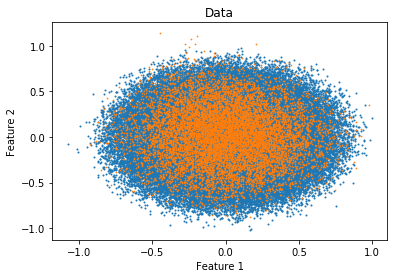

In [116]:
"""Plot decoded samples from latent space"""

num_samples_to_generate = 10000

model.eval()

# seed = 42
# rng = np.random.RandomState(seed)
# Sample latent vectors
z = model.sample_latent_space(num_samples_to_generate)
# z = Variable(torch.Tensor(rng.randn(num_samples_to_generate, latent_vec_size).astype(np_dtype)))
# Compute decoded value
x = model.decode(z)
x = x.data.numpy()
noise = sigma_x * rng.randn(num_samples_to_generate, num_features)
x += noise

# Plot data
plt.clf()
plt.scatter(data[:, 0], data[:, 1], s=1)
plt.scatter(x[:, 0], x[:, 1], s=.5)
plt.title("Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


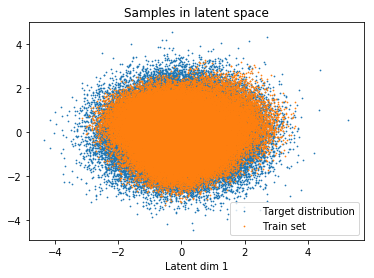

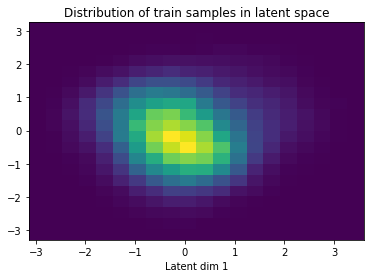

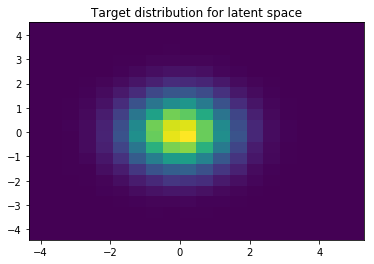

In [118]:
"""Plot samples in latent space"""

model.eval()
latent_samples_mu = []
latent_samples_logvar = []
for i, (x, _) in enumerate(train_loader):
    x = Variable(x.type(dtype), volatile=True)
    recon_x, mu, logvar = model(x)
    latent_samples_mu.append(mu.data.numpy())
    latent_samples_logvar.append(logvar.data.numpy())
latent_samples_mu = np.concatenate(latent_samples_mu, axis=0)
latent_samples_logvar = np.concatenate(latent_samples_logvar, axis=0)

latent_dim1 = 0
latent_dim2 = 1
x = latent_samples_mu[..., latent_dim1].ravel()
y = latent_samples_mu[..., latent_dim2].ravel()
# Generate samples from target latent distribution, i.e. N(0, I)
target_x, target_y = np.random.randn(len(x)), np.random.randn(len(x))

plt.figure()
plt.scatter(target_x, target_y, s=0.5)
plt.scatter(x, y, s=0.5)
plt.title("Samples in latent space")
plt.xlabel("Latent dim {:d}".format(latent_dim1))
plt.xlabel("Latent dim {:d}".format(latent_dim2))
plt.legend(["Target distribution", "Train set"])
plt.show()
plt.close()

plt.figure()
plt.hist2d(x, y, 20)
plt.title("Distribution of train samples in latent space")
plt.xlabel("Latent dim {:d}".format(latent_dim1))
plt.xlabel("Latent dim {:d}".format(latent_dim2))
plt.show()
plt.close()

plt.figure()
plt.hist2d(target_x, target_y, 20)
plt.title("Target distribution for latent space")
plt.show()
plt.close()

In [106]:
"""Interpolate between data points"""

model.eval()
for i in range(10):
    # seed = 46
    # rng = np.random.RandomState(seed)
    idx1, idx2 = rng.choice(np.arange(num_samples), size=2, replace=False)
    print(idx1, idx2)
    x1, mu1, sigma1 = model(Variable(torch.Tensor(data[idx1, :]).type(dtype), volatile=True))
    x2, mu2, sigma2 = model(Variable(torch.Tensor(data[idx2, :]).type(dtype), volatile=True))
    w = Variable(torch.linspace(0, 1, 1000))
    z = mu1 + (mu2 - mu1) * w[:, None]
    x = model.decode(z)

    x1 = x1.data.numpy()
    x2 = x2.data.numpy()
    x = x.data.numpy()

    plt.figure()
    plt.scatter(data[:, 0], data[:, 1], s=0.001)
    plt.plot(data[[idx1, idx2], 0], data[[idx1, idx2], 1], 'x')
    plt.plot([x1[0], x2[0]], [x1[1], x2[1]], 'o')
    plt.plot(x[:, 0], x[:, 1], '.')
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.show()


SyntaxError: invalid syntax (<ipython-input-106-95ce55d3c50c>, line 1)